# Sentiment Analysis

## About the Dataset

Kaggle: https://www.kaggle.com/datasets/nursyahrina/chat-sentiment-dataset

A Simple but Rich Dataset for Sentiment Analysis of Chat Messages.

This dataset contains a collection of chat messages that can be used to develop a sentiment analysis machine learning model to classify messages into 3 sentiment classes - positive, negative, and neutral. The messages are diverse in nature, containing not only simple text but also special characters, numbers, emoji/emoticons, and URL addresses. The dataset can be used for various natural language processing tasks related to chat analysis.

## Libraries

In [94]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import seaborn as sns

import matplotlib.pyplot as plt

from wordcloud import WordCloud
import collections

from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
from catboost import CatBoostClassifier

## Data

In [2]:
df = pd.read_csv('chat_dataset.csv')
df.sample(10)

,message,sentiment
17,The internet speed is slow,negative
132,I did not enjoy this,negative
577,I got a bad haircut and now I have to wear a h...,negative
303,I can't wait to come back here,positive
217,This phone is standard,neutral
349,I'm feeling a bit overwhelmed 😰,neutral
492,I had a terrible day at work today 😞,negative
413,I'm just trying to make the most of every day 🌞,neutral
265,The hike was regular,neutral
321,The product exceeded my expectations,positive


What is the the distribution of sentiments in the given dataset?

-> Most of the sentiments in the dataset are neutral, followed by positive sentiments and the fewest sentences in the dataset are negative.

In [3]:
df['sentiment'].value_counts()

neutral     259
positive    178
negative    147
Name: sentiment, dtype: int64

<AxesSubplot:>

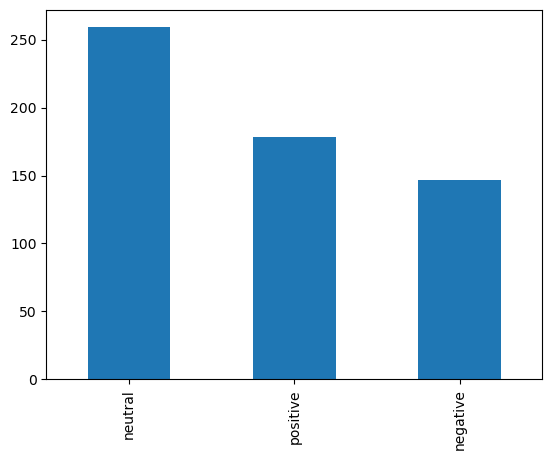

In [4]:
df.sentiment.value_counts().plot(kind = 'bar')

Checking if there is a NaN. (No, it's not.)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    584 non-null    object
 1   sentiment  584 non-null    object
dtypes: object(2)
memory usage: 9.2+ KB


## Preprocessing

Mostly from: https://www.kaggle.com/code/micaeld/chat-sentiment-classification

In [6]:
# Variable to replace all characters that are not letters or whitespace
regex = re.compile('[^a-z\s]')

# Convert text to lower case
df['clean_text'] = df['message'].str.lower()

# Removes all characters that are not letters or spaces
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', x))

# Removes all characters between square brackets
df['clean_text'] = df['clean_text'].str.replace('[%s]', '', regex = True)

# Remove the accents
df['clean_text'] = df['clean_text'].apply(lambda x: regex.sub('', unidecode(x)))

# Remove ing
df['clean_text'] = df['clean_text'].str.replace('ing', '', regex = True)

# Remove words with less than 3 characters
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [21]:
# Function to correct the words
def correct_spelling(text):
    blob = TextBlob(text)
    return str(blob.correct())

# Apply the function
df['corrected_text'] = df['clean_text'].apply(correct_spelling)

# Result
df['corrected_text'].sample(10)

495                 can believe failed that exam
505                 disappointed someone trusted
442                enjoy the muchneeded vacation
53                         very pleased with the
482    but completed difficult take and feel may
257                              have preference
277                             have opinion the
576       mind flight and had buy new ticket for
171                    ratified with the product
160                         the hotel overpriced
Name: corrected_text, dtype: object

In [8]:
# Tokenization
df['text_without_stopwords'] = df['corrected_text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['text_without_stopwords'] = df['text_without_stopwords'].apply(lambda x: [word for word in x if word not in stop_words])

# Result
df['text_without_stopwords'].head()

0    [really, enjoyed, movie]
1            [food, terrible]
2                      [feel]
3        [service, excellent]
4           [bad, experience]
Name: text_without_stopwords, dtype: object

In [9]:
# Joining the words back into a single text
df['final_text'] = df['text_without_stopwords'].apply(lambda x: ' '.join(x))

# Result
df['final_text'].head()

0    really enjoyed movie
1           food terrible
2                    feel
3       service excellent
4          bad experience
Name: final_text, dtype: object

## Visualizations

Which words were used most frequently in this dataset?

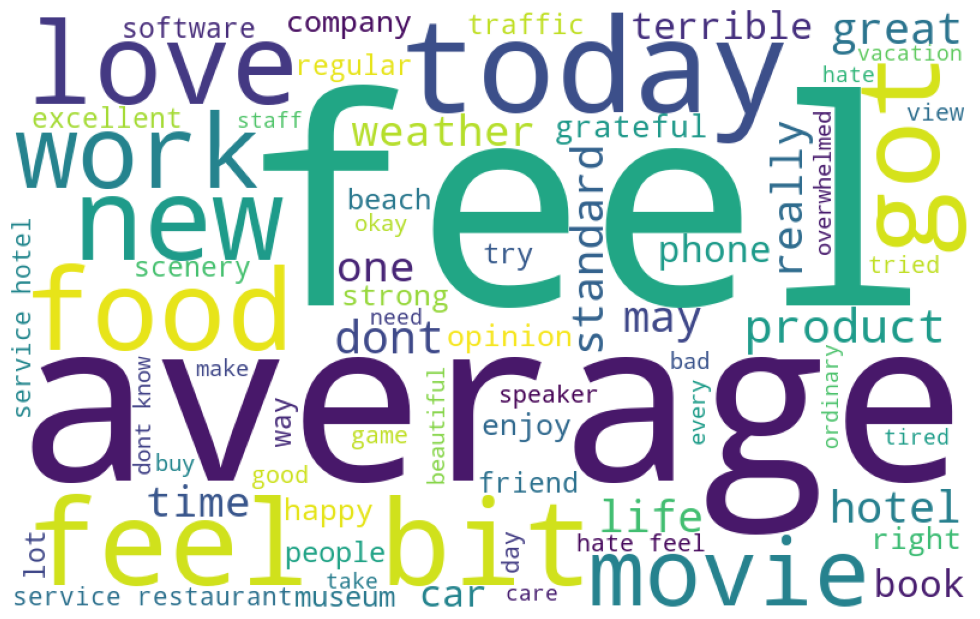

In [27]:
text = ' '.join(caption for caption in df['final_text'])

wordcloud = WordCloud(width = 800, height = 500, background_color = 'white', 
                min_font_size = 14).generate(text)

plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

dict_values([66, 31, 28, 26, 26, 25, 24, 24, 23, 22])

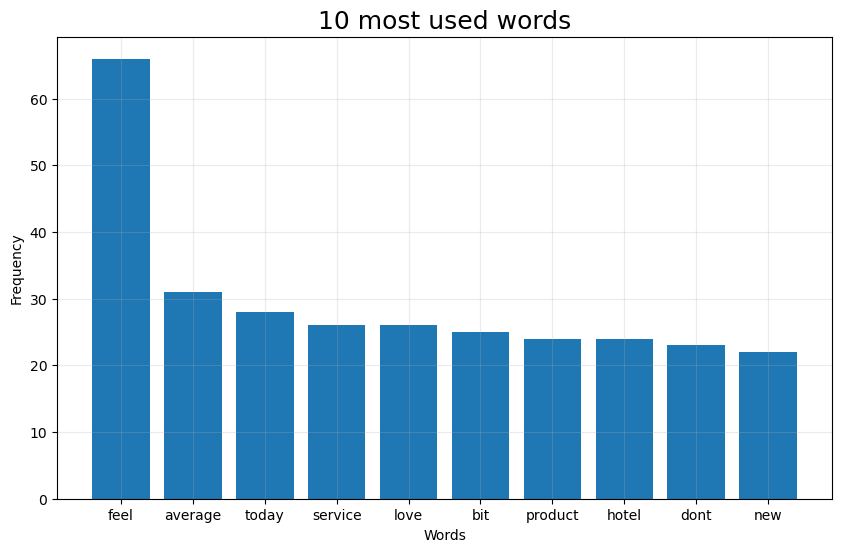

In [42]:
words = []
for text in df['final_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

plt.figure(figsize = (10, 6))

plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

plt.xticks(range(len(top_words)), list(top_words.keys()))

plt.grid(alpha = 0.25)

plt.title('10 most used words', fontsize = 18)

plt.xlabel('Words')
plt.ylabel('Frequency')

top_words.values()

In the clean dataset "feel" was written 66 times, on the second place is "average" with 31 times and then are following the words "today", "service" and "love" with 28 and 26 times.

## Training

In [43]:
df['sentiment'] = df['sentiment'].map({'neutral' : 0, 'positive' : 1, 'negative' : 2})
df['sentiment']

0      1
1      2
2      0
3      1
4      2
      ..
579    2
580    2
581    2
582    2
583    2
Name: sentiment, Length: 584, dtype: int64

In [106]:
x = np.array(df['final_text'])
y = np.array(df['sentiment'])

# Convert text to numerical
cv = CountVectorizer()
X = cv.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20, shuffle=True)

#### Logistic Regression

In [107]:
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

In [108]:
def print_metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
    
# Metrics for Logistic Regression
print('Metrics for Logistic Regression:')
print_metrics(y_test, y_pred_lr)

Metrics for Logistic Regression:
Accuracy:  0.7945205479452054
Precision:  0.7979848733273391
Recall:  0.7945205479452054
F1 Score:  0.7905815645541673


#### CatBoost 

In [109]:
catboost = CatBoostClassifier(verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)

In [110]:
print('Metrics for CatBoost:')
print_metrics(y_test, y_pred_catboost)

Metrics for CatBoost:
Accuracy:  0.8082191780821918
Precision:  0.8208451729646437
Recall:  0.8082191780821918
F1 Score:  0.8041046550180277


#### Support Vector Machine (RBF Kernel)

In [111]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [112]:
print('Metrics for Support Vector Machine (RBF Kernel):')
print_metrics(y_test, y_pred_svm)

Metrics for Support Vector Machine (RBF Kernel):
Accuracy:  0.726027397260274
Precision:  0.7206111930427379
Recall:  0.726027397260274
F1 Score:  0.7140154109589041


#### Support Vector Machine (Linear Kernel)

In [113]:
linear_svm = LinearSVC()
linear_svm.fit(X_train, y_train)
y_pred_linsvm = linear_svm.predict(X_test)

In [114]:
print('Metrics for Support Vector Machine (Linear Kernel):')
print_metrics(y_test, y_pred_linsvm)

Metrics for Support Vector Machine (Linear Kernel):
Accuracy:  0.8493150684931506
Precision:  0.8507350484463748
Recall:  0.8493150684931506
F1 Score:  0.848274615353714


The SVM (linear kernel) has the highest accuracy with 85.47%. It is the best algorithm for this dataset. 

## Confusion Matrix

In [115]:
linear_svm = LinearSVC()
linear_svm.fit(X_test, y_test)
y_pred = linear_svm.predict(X_test)

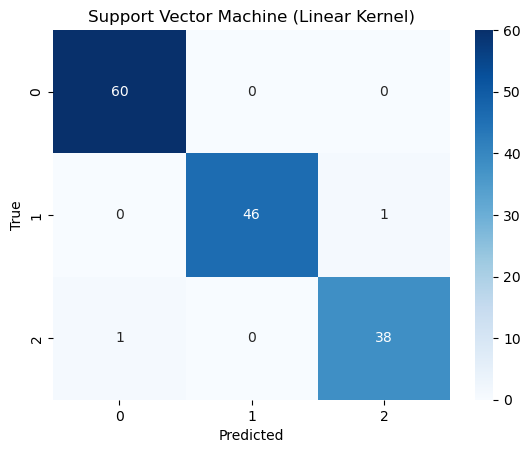

In [116]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Support Vector Machine (Linear Kernel)")
plt.show()

# Literature

* https://www.kaggle.com/code/micaeld/chat-sentiment-classification
* https://www.kaggle.com/code/sabirbagwan/chatanalysisnlp
* https://realpython.com/python-nltk-sentiment-analysis/
* https://matplotlib.org/stable/tutorials/introductory/customizing.html
* Notebooks from the course
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html
* https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier